**Import packages**

In [1]:
import os
import json
from collections import Counter, defaultdict
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
import random

**I) DATA ANALYSIS**

**I) 1.Check the file exist**

In [16]:

train_json = "/kaggle/input/detection-data/labels/bdd100k_labels_images_train.json"
val_json   = "/kaggle/input/detection-data/labels/bdd100k_labels_images_val.json"

train_images_dir = "/kaggle/input/detection-data/images/100k/train"
val_images_dir   = "/kaggle/input/detection-data/images/100k/val"

print("\n=== File Check ===")
print("Train data json exists:", os.path.exists(train_json))
print("Val data json exists:", os.path.exists(val_json))
print("Train images folder exists:", os.path.exists(train_images_dir))
print("Val images folder exists:", os.path.exists(val_images_dir))


=== File Check ===
Train data json exists: True
Val data json exists: True
Train images folder exists: True
Val images folder exists: True


**I) 2.Load the JSON Annotation Files**

In [3]:
with open(train_json, 'r') as f:
    train_data = json.load(f)

with open(val_json, 'r') as f:
    val_data = json.load(f)

print(f"\n number of Loaded JSON: {len(train_data)} train frames, {len(val_data)} val frames")


 number of Loaded JSON: 69863 train frames, 10000 val frames


**I) 3.Get the number of annotated datas**


In [4]:
train_records = []
for frame in train_data:
    img_name = frame['name']
    for label in frame['labels']:
        train_records.append({
            "image": img_name,
            "category": label['category'],
            "box2d": label.get('box2d', {})
        })

val_records = []
for frame in val_data:
    img_name = frame['name']
    for label in frame['labels']:
        val_records.append({
            "image": img_name,
            "category": label['category'],
            "box2d": label.get('box2d', {})
        })

print(f"\nNumber of objects present in Train data: {len(train_records)}")
print(f"Number of objects present in the Val datas: {len(val_records)}")


Number of objects present in Train data: 1941237
Number of objects present in the Val datas: 279237


**I) 4. Check for missing datas & Check unique image counts in labels**

In [5]:
#unique labels
unique_train_images_in_labels = set([r["image"] for r in train_records])
unique_val_images_in_labels = set([r["image"] for r in val_records])

# actual number of files in image folder
actual_train_images = set(os.listdir(train_images_dir))
actual_val_images = set(os.listdir(val_images_dir))


print(f"Number of Unique images in TRAIN labels: {len(unique_train_images_in_labels)}")
print(f"Number of Unique images in VAL labels: {len(unique_val_images_in_labels)}")
print(f"Number of Actual image files in TRAIN folder: {len(actual_train_images)}")
print(f"Number of Actual image files in VAL folder: {len(actual_val_images)}")

# Check for mismatches/get the count missing datas
missing_in_folder_train = unique_train_images_in_labels - actual_train_images
missing_in_labels_train = actual_train_images - unique_train_images_in_labels

missing_in_folder_val = unique_val_images_in_labels - actual_val_images
missing_in_labels_val = actual_val_images - unique_val_images_in_labels

print(f"\nTRAIN DATA INFO: Labeled but missing in folder: {len(missing_in_folder_train)}")
print(f"TRAIN DATA INFO: In folder but not labeled: {len(missing_in_labels_train)}")
print(f"\nVAL DATA INFO: Labeled but missing in folder: {len(missing_in_folder_val)}")
print(f"VAL DATA INFO: In folder but not labeled: {len(missing_in_labels_val)}")


Number of Unique images in TRAIN labels: 69863
Number of Unique images in VAL labels: 10000
Number of Actual image files in TRAIN folder: 70000
Number of Actual image files in VAL folder: 10000

TRAIN DATA INFO: Labeled but missing in folder: 0
TRAIN DATA INFO: In folder but not labeled: 137

VAL DATA INFO: Labeled but missing in folder: 0
VAL DATA INFO: In folder but not labeled: 0


**I) 5.Visualize the category/class distributions**


Train category counts: Counter({'car': 713211, 'lane': 528643, 'traffic sign': 239686, 'traffic light': 186117, 'drivable area': 125723, 'person': 91349, 'truck': 29971, 'bus': 11672, 'bike': 7210, 'rider': 4517, 'motor': 3002, 'train': 136})
Val category counts: Counter({'car': 102506, 'lane': 75730, 'traffic sign': 34908, 'traffic light': 26885, 'drivable area': 17981, 'person': 13262, 'truck': 4245, 'bus': 1597, 'bike': 1007, 'rider': 649, 'motor': 452, 'train': 15})


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


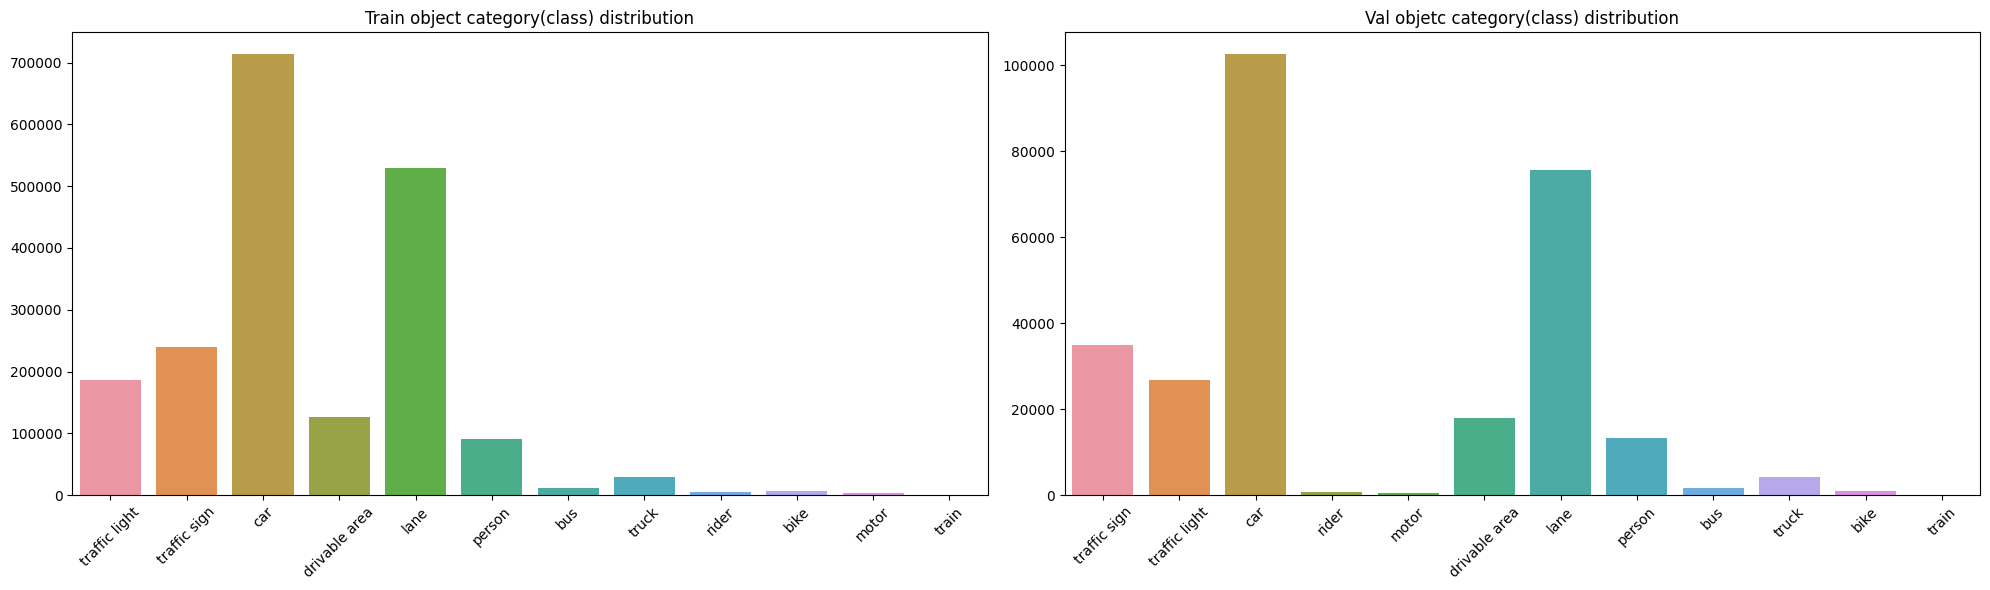

In [6]:
train_cat_counts = Counter([r["category"] for r in train_records])
val_cat_counts = Counter([r["category"] for r in val_records])

print("\nTrain category counts:", train_cat_counts)
print("Val category counts:", val_cat_counts)

fig=plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_cat_counts.keys()), y=list(train_cat_counts.values()))
plt.title("Train object category(class) distribution")
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.barplot(x=list(val_cat_counts.keys()), y=list(val_cat_counts.values()))
plt.title("Val objetc category(class) distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Note: The initial distribution showed 12 unique classes in the dataset. 
To verify the expected number of classes, I searched online for the official class 
definitions used in BDD100K object detection and also reviewed the assignment
document. Both sources confirmed that only 10 classes are required for this task.
Based on that, I filtered and retained only the relevant 10 classes from the dataset.**



**I) 6.get 10 Classes**

In [7]:
bdd10_classes = [
    'bike', 'bus', 'car', 'motor', 'person', 'rider',
    'traffic light', 'traffic sign', 'train', 'truck'
]

train_records_10 = [r for r in train_records if r["category"] in bdd10_classes]
val_records_10   = [r for r in val_records if r["category"] in bdd10_classes]

print(f"\nFiltered train data objects (10-class): {len(train_records_10)}")
print(f"Filtered val data objects (10-class): {len(val_records_10)}")


Filtered train data objects (10-class): 1286871
Filtered val data objects (10-class): 185526


**I) 7. visualization**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


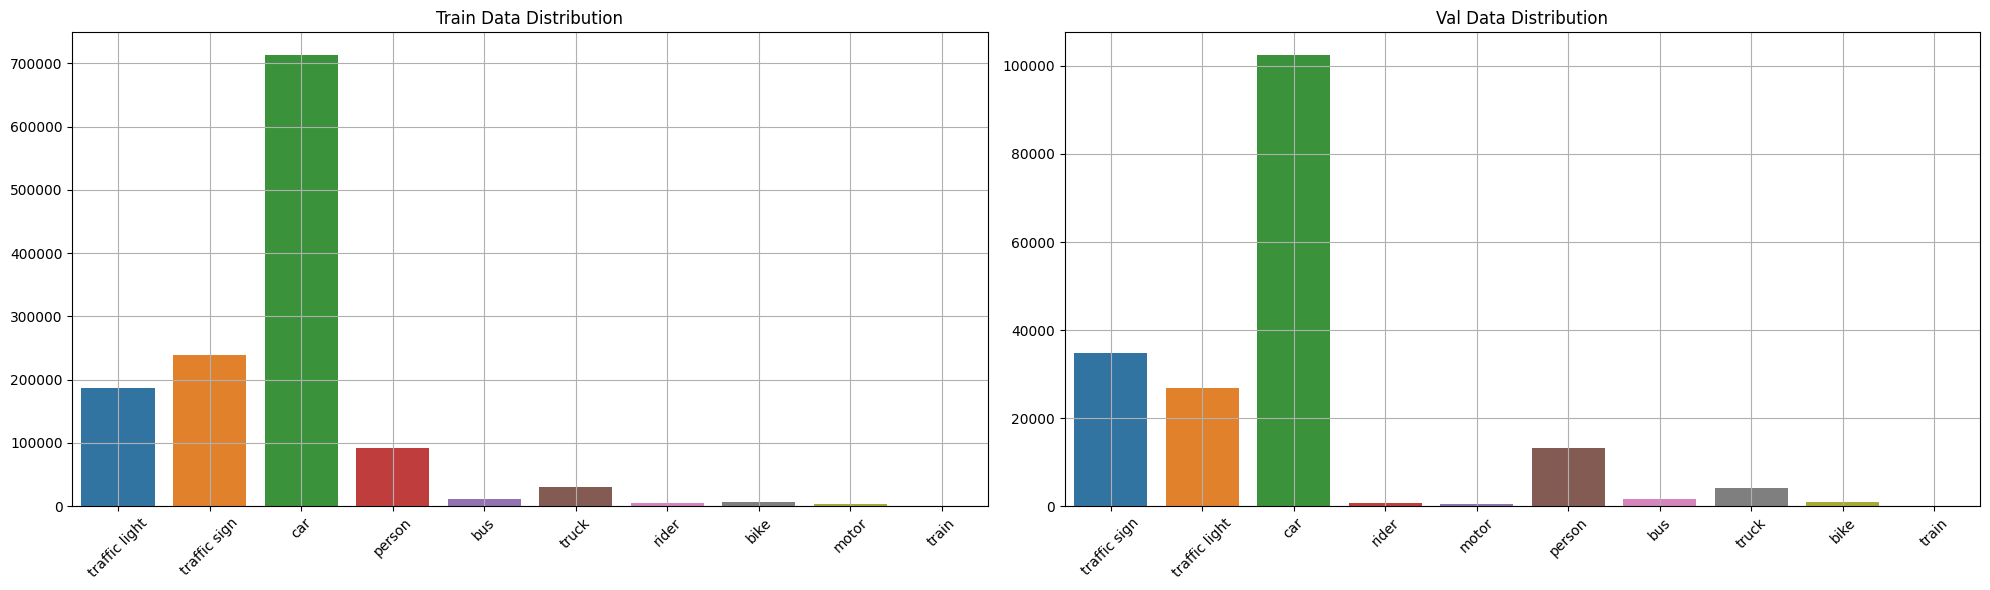

In [8]:
train_cat_counts_10 = Counter([r["category"] for r in train_records_10])
val_cat_counts_10 = Counter([r["category"] for r in val_records_10])

fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_cat_counts_10.keys()), y=list(train_cat_counts_10.values()))
plt.title("Train Data Distribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.subplot(1, 2, 2)
sns.barplot(x=list(val_cat_counts_10.keys()), y=list(val_cat_counts_10.values()))
plt.title("Val Data Distribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


**I) 8. Anomaly Detection-Missing datas**

In [10]:
missing_train_classes = set(bdd10_classes) - set(train_cat_counts_10.keys())
missing_val_classes = set(bdd10_classes) - set(val_cat_counts_10.keys())

print("Missing classes in train:", missing_train_classes)
print("Missing classes in val:", missing_val_classes)

#least class check
print("Low-frequency classes in train (count < 1000):")
for cls, count in train_cat_counts_10.items():
    if count < 10000:
        print(f"{cls}: {count}")


Missing classes in train: set()
Missing classes in val: set()
Low-frequency classes in train (count < 1000):
rider: 4517
bike: 7210
motor: 3002
train: 136


**Model Training: Setup YoloV8 datas**

In [11]:
#Step 1: Setup Clean Directory

import os


base_dir = "/kaggle/working/bdd10_yolo_ready"

image_train_dir = os.path.join(base_dir, "images/train")
image_val_dir   = os.path.join(base_dir, "images/val")
label_train_dir = os.path.join(base_dir, "labels/train")
label_val_dir   = os.path.join(base_dir, "labels/val")

for d in [image_train_dir, image_val_dir, label_train_dir, label_val_dir]:
    os.makedirs(d, exist_ok=True)

# Class name to ID map
bdd10_classes = [
    'bike', 'bus', 'car', 'motor', 'person', 'rider',
    'traffic light', 'traffic sign', 'train', 'truck'
]
class_to_id = {cls: i for i, cls in enumerate(bdd10_classes)}


In [12]:
#Step 2: Convert BDD JSON to YOLO Format
import shutil

def convert_records_to_yolo(records, image_out_dir, label_out_dir):
    from collections import defaultdict

    # Group annotations by image
    grouped = defaultdict(list)
    for r in records:
        grouped[r["image_path"]].append(r)

    for img_path, objs in grouped.items():
        fname = os.path.basename(img_path)
        name_no_ext = os.path.splitext(fname)[0]
        label_path = os.path.join(label_out_dir, name_no_ext + ".txt")
        out_img_path = os.path.join(image_out_dir, fname)

        # Copy image
        try:
            shutil.copy(img_path, out_img_path)
        except Exception as e:
            print(f"Error copying image {img_path}: {e}")
            continue

        with open(label_path, "w") as f:
            for r in objs:
                cls_id = class_to_id[r["category"]]
                x, y, w, h = r["bbox"]
                img_w, img_h = r["width"], r["height"]

                # Convert to YOLO format
                x_center = (x + w / 2) / img_w
                y_center = (y + h / 2) / img_h
                norm_w = w / img_w
                norm_h = h / img_h

                f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")


In [18]:
import os, json, shutil
from collections import defaultdict

# STEP 1: Configuration
train_images_dir = "/kaggle/input/detection-data/images/100k/train"
val_images_dir   = "/kaggle/input/detection-data/images/100k/val"
train_json_path  = "/kaggle/input/detection-data/labels/bdd100k_labels_images_train.json"
val_json_path    = "/kaggle/input/detection-data/labels/bdd100k_labels_images_val.json"
output_base      = "/kaggle/working/bdd10_yolo_ready"

# STEP 2: YOLOv8 folder structure
image_train_dir = os.path.join(output_base, "images/train")
image_val_dir   = os.path.join(output_base, "images/val")
label_train_dir = os.path.join(output_base, "labels/train")
label_val_dir   = os.path.join(output_base, "labels/val")
for d in [image_train_dir, image_val_dir, label_train_dir, label_val_dir]:
    os.makedirs(d, exist_ok=True)

# STEP 3: BDD100K 10-Class Setup
bdd10_classes = [
    'bike', 'bus', 'car', 'motor', 'person', 'rider',
    'traffic light', 'traffic sign', 'train', 'truck'
]
class_to_id = {cls: i for i, cls in enumerate(bdd10_classes)}

# STEP 4: Parse BDD100K "labels" format JSON
def load_bdd_label_json(json_path, image_dir):
    with open(json_path, "r") as f:
        data = json.load(f)

    records = []
    for item in data:
        if "labels" not in item:
            continue
        name = item["name"]
        width = item.get("width", 1280)
        height = item.get("height", 720)
        for obj in item["labels"]:
            category = obj.get("category")
            box2d = obj.get("box2d")
            if category in bdd10_classes and box2d:
                x1, y1 = box2d["x1"], box2d["y1"]
                x2, y2 = box2d["x2"], box2d["y2"]
                bbox = [x1, y1, x2 - x1, y2 - y1]
                records.append({
                    "category": category,
                    "bbox": bbox,
                    "width": width,
                    "height": height,
                    "name": name,
                    "image_path": os.path.join(image_dir, name)
                })
    return records

# Load both train and val data
train_records_10 = load_bdd_label_json(train_json_path, train_images_dir)
val_records_10   = load_bdd_label_json(val_json_path, val_images_dir)

# STEP 5: Convert to YOLO format & copy image
def convert_records_to_yolo(records, image_out_dir, label_out_dir, class_to_id):
    grouped = defaultdict(list)
    for r in records:
        grouped[r["image_path"]].append(r)

    for img_path, objs in grouped.items():
        fname = os.path.basename(img_path)
        name_no_ext = os.path.splitext(fname)[0]
        label_path = os.path.join(label_out_dir, name_no_ext + ".txt")
        out_img_path = os.path.join(image_out_dir, fname)

        try:
            shutil.copy(img_path, out_img_path)
        except Exception as e:
            print(f" Failed to copy image: {img_path}\n{e}")
            continue

        with open(label_path, "w") as f:
            for r in objs:
                cls_id = class_to_id[r["category"]]
                x, y, w, h = r["bbox"]
                img_w, img_h = r["width"], r["height"]

                # Convert to YOLO format
                x_center = (x + w / 2) / img_w
                y_center = (y + h / 2) / img_h
                norm_w = w / img_w
                norm_h = h / img_h

                f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")

# STEP 6: Perform the conversion
convert_records_to_yolo(train_records_10, image_train_dir, label_train_dir, class_to_id)
convert_records_to_yolo(val_records_10, image_val_dir, label_val_dir, class_to_id)

print("✅ JSON to YOLO conversion complete.")
print(f"Labels saved in: {os.path.join(output_base, 'labels')}")
print(f"Images saved in: {os.path.join(output_base, 'images')}")


✅ JSON to YOLO conversion complete.
Labels saved in: /kaggle/working/bdd10_yolo_ready/labels
Images saved in: /kaggle/working/bdd10_yolo_ready/images


In [19]:
bdd10_classes = [
    'bike', 'bus', 'car', 'motor', 'person', 'rider',
    'traffic light', 'traffic sign', 'train', 'truck'
]

data_yaml_content = f"""
path: /kaggle/working/bdd10_yolo_ready
train: images/train
val: images/val
nc: 10
names: {bdd10_classes}
"""

# Save to file
yaml_path = "/kaggle/working/bdd10_yolo_ready/data.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml_content.strip())

print(f"✅ data.yaml created at: {yaml_path}")


✅ data.yaml created at: /kaggle/working/bdd10_yolo_ready/data.yaml


In [ ]:
!pip install ultralytics

**Model Training Usng Yolov8 including all dataset**

In [ ]:
from ultralytics import YOLO

# Step 2: Define model
model = YOLO('yolov8n.yaml')  

# Step 3: Train the model
model.train(
    data='/kaggle/working/bdd10_yolo_ready/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    device=0  
)


In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


CUDA Available: False


**I used the same procedures to run the code on both Kaggle and Google Colab; only the file paths were different. Due to GPU availability issues, I couldn't complete the training. So, I am presenting the approach I followed for the given assignment.
The code below is used to train images in small batches. In this case as well, I couldn't complete the training. To reuse the code, the paths need to be modified based on the user's setup**

**Model Training using batch of dataset--Tried extra step in colab**

In [ ]:
import os
import glob
import yaml

# Your original dataset paths
train_image_dir = "/content/drive/MyDrive/bdd10_yolo_ready/bdd100k_images_100k/bdd100k/images/100k/train"
train_label_dir = "/content/drive/MyDrive/bdd10_yolo_ready/bdd100k_images_100k/bdd100k/labels/train"
val_image_dir   = "/content/drive/MyDrive/bdd10_yolo_ready/bdd100k_images_100k/bdd100k/images/100k/val"
val_label_dir   = "/content/drive/MyDrive/bdd10_yolo_ready/bdd100k_images_100k/bdd100k/labels/val"

data_yaml_path  = "/content/drive/MyDrive/data.yaml"
batch_txt_dir   = "/content/drive/MyDrive/yolos/batch_txts"  # temp lists
os.makedirs(batch_txt_dir, exist_ok=True)

# Get full list of images
image_list = sorted(glob.glob(os.path.join(train_image_dir, "*.jpg")))
label_list = sorted(glob.glob(os.path.join(train_label_dir, "*.txt")))
assert len(image_list) == len(label_list), "Mismatch in image-label count!"

batch_size = 100
num_batches = (len(image_list) + batch_size - 1) // batch_size

print(f"Found {len(image_list)} training images, splitting into {num_batches} batches")

# Class names
class_names = ['bike', 'bus', 'car', 'motor', 'person', 'rider', 'traffic light', 'traffic sign', 'train', 'truck']

#Train each batch without copying data
prev_model = "yolov8n.pt"

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(image_list))
    batch_imgs = image_list[start_idx:end_idx]

    # Generate image list file (YOLOv8 supports txt listing)
    batch_txt_path = os.path.join(batch_txt_dir, f"batch{i+1}.txt")
    with open(batch_txt_path, 'w') as f:
        for img_path in batch_imgs:
            f.write(img_path + '\n')

    # Generate temporary data.yaml for current batch
    data_yaml = {
        "path": "",  # not used with txt list
        "train": batch_txt_path,
        "val": val_image_dir,
        "names": class_names
    }

    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml, f)

    run_name = f"batch_{i+1}"
    print(f"\n Training batch {i+1} ({len(batch_imgs)} images) using weights: {prev_model}")

    # Train with current batch
    !yolo task=detect mode=train model={prev_model} data={data_yaml_path} epochs=5 imgsz=640 name={run_name}

    # Update model path for next batch
    prev_model = f"runs/detect/{run_name}/weights/best.pt"


**Due to the training failure, I was unable to perform metrics evaluation and testing**